## PRÉDICTION DE MATCHS DE LIGUE 1

**Données :** 8 saisons (2017-2025) - 2791 matchs

### 1. Import des bibliothèques

In [68]:
print("-"*50)
print(f"Nombre total de matchs : {len(df)}")
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns

--------------------------------------------------
Nombre total de matchs : 2791


### 2. PRÉPARATION DES DONNÉES / PREPROCESSING

1. **Chargement de tous les fichiers de données**
2. **Fusion dans un seul DataFrame**
3. **Sélection des colonnes nécessaires**

In [69]:
# Charger tous les fichiers
dossier_data = 'data'
fichiers = sorted([f for f in os.listdir(dossier_data) if f.endswith('.csv')])

# Combiner en un seul DataFrame
df_list = []
for fichier in fichiers:
    df_temp = pd.read_csv(os.path.join(dossier_data, fichier))
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Garder uniquement les colonnes nécessaires (PS: voir lexique dans github)
colonnes_necessaires = [
    'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',
    'HTHG', 'HTAG',
    'HS', 'AS', 'HST', 'AST',
    'HF', 'AF', 'HC', 'AC',
    'HY', 'AY', 'HR', 'AR',
]

df = df[colonnes_necessaires]

4. **Gestion des valeurs manquantes**

In [70]:
# Vérifier les valeurs manquantes
print(df.isnull().sum())

# Supprimer les lignes avec des valeurs manquantes (si nécessaire)
df = df.dropna()

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


5. **Conversion des dates au format datetime**
6. **Création d'une colonne 'Saison' pour identifier chaque saison**
7. **Encodage de la variable cible**

In [71]:
# Transformer la Date du dataset en datetime.
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Créer une colonne saison (en ligue 1, une saison va d'août à mai)
def col_saison(date):
    if date.month >= 8:
        return f"{date.year}-{date.year+1}"
    else:
        return f"{date.year-1}-{date.year}"

df['Saison'] = df['Date'].apply(col_saison)

# FTR, notre variable cible, est en lettres (H, D, A), il faut donc la transformer en chiffres
df['FTR_encoded'] = LabelEncoder().fit_transform(df['FTR'])
# A (Away win) → 0
# D (Draw) → 1  
# H (Home win) → 2

print(df[['FTR', 'FTR_encoded']].head(10))

  FTR  FTR_encoded
0   H            2
1   H            2
2   A            0
3   H            2
4   H            2
5   H            2
6   D            1
7   D            1
8   H            2
9   H            2


/var/folders/y8/gpytstt55lz40g5vk34_91680000gn/T/ipykernel_1270/1719217414.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


### 3. FEATURE ENGINEERING

In [72]:
# Fonction pour calculer les stats des N derniers matchs d'une équipe
def get_team_stats(df, team, date, saison, n_matches=5):
    # Matchs précédents de l'équipe dans la même saison
    mask = (
        (df['Saison'] == saison) & 
        (df['Date'] < date) & 
        ((df['HomeTeam'] == team) | (df['AwayTeam'] == team))
    )
    previous_matches = df[mask].tail(n_matches)
    
    if len(previous_matches) == 0:
        # Pas d'historique : valeurs par défaut
        return {
            'buts_marques': 0,
            'buts_concedes': 0,
            'victoires': 0,
            'nuls': 0,
            'defaites': 0,
            'tirs': 0,
            'tirs_cadres': 0
        }
    
    buts_marques = 0
    buts_concedes = 0
    victoires = 0
    nuls = 0
    defaites = 0
    tirs = 0
    tirs_cadres = 0
    
    for _, match in previous_matches.iterrows():
        if match['HomeTeam'] == team:
            buts_marques += match['FTHG']
            buts_concedes += match['FTAG']
            tirs += match['HS']
            tirs_cadres += match['HST']
            if match['FTR'] == 'H':
                victoires += 1
            elif match['FTR'] == 'D':
                nuls += 1
            else:
                defaites += 1
        else:  # AwayTeam
            buts_marques += match['FTAG']
            buts_concedes += match['FTHG']
            tirs += match['AS']
            tirs_cadres += match['AST']
            if match['FTR'] == 'A':
                victoires += 1
            elif match['FTR'] == 'D':
                nuls += 1
            else:
                defaites += 1
    
    n = len(previous_matches)
    return {
        'buts_marques': buts_marques / n,
        'buts_concedes': buts_concedes / n,
        'victoires': victoires,
        'nuls': nuls,
        'defaites': defaites,
        'tirs': tirs / n,
        'tirs_cadres': tirs_cadres / n
    }

# Appliquer à chaque match
print("Calcul des features en cours...")

home_stats = []
away_stats = []

for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Match {idx}/{len(df)}")
    
    h_stats = get_team_stats(df, row['HomeTeam'], row['Date'], row['Saison'])
    a_stats = get_team_stats(df, row['AwayTeam'], row['Date'], row['Saison'])
    
    home_stats.append(h_stats)
    away_stats.append(a_stats)

# Convertir en colonnes
for key in home_stats[0].keys():
    df[f'Home_{key}'] = [s[key] for s in home_stats]
    df[f'Away_{key}'] = [s[key] for s in away_stats]

print("-"*50)
# On affiche un match au hasard pour avoir un aperçu
print(df.iloc[2147])

Calcul des features en cours...
Match 0/2791
Match 100/2791
Match 200/2791
Match 300/2791
Match 400/2791
Match 500/2791
Match 600/2791
Match 700/2791
Match 800/2791
Match 900/2791
Match 1000/2791
Match 1100/2791
Match 1200/2791
Match 1300/2791
Match 1400/2791
Match 1500/2791
Match 1600/2791
Match 1700/2791
Match 1800/2791
Match 1900/2791
Match 2000/2791
Match 2100/2791
Match 2200/2791
Match 2300/2791
Match 2400/2791
Match 2500/2791
Match 2600/2791
Match 2700/2791
--------------------------------------------------
Date                  2023-05-14 00:00:00
HomeTeam                           Monaco
AwayTeam                            Lille
FTHG                                    0
FTAG                                    0
FTR                                     D
HTHG                                    0
HTAG                                    0
HS                                      8
AS                                     10
HST                                     1
AST                

### 4. SÉPARATION DES DONNÉES

In [73]:
# Les colonnes qu'on va utiliser pour prédire
feature_columns = [col for col in df.columns if col.startswith('Home_') or col.startswith('Away_')]

X = df[feature_columns]
y = df['FTR_encoded']

print(f"Nombre de features : {len(feature_columns)}")
print(f"Shape de X : {X.shape}")
print("-"*50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% pour le test
    random_state=42  # Pour avoir toujours le même découpage
)

print(f"Train : {len(X_train)} matchs")
print(f"Test : {len(X_test)} matchs")

Nombre de features : 14
Shape de X : (2791, 14)
--------------------------------------------------
Train : 2232 matchs
Test : 559 matchs


### 5. ENTRAÎNEMENT DU MODÈLE

In [74]:
# Créer et entraîner le modèle avec RandomForest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # 100 arbres
    max_depth=10,      # Profondeur max
    random_state=42
)

rf_model.fit(X_train, y_train)

# Prédire sur le test
y_pred = rf_model.predict(X_test)

# Évaluer
accuracy = accuracy_score(y_test, y_pred)
print("### RANDOMFOREST CLASSIFIER ###")
print("\n")
print("="*30)
print(f"Accuracy : {accuracy:.2%}")
print("="*30)

# Rapport détaillé
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Away win', 'Draw', 'Home win']))
print("-"*50)
# Matrice de confusion
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\n(lignes = vrai résultat, colonnes = prédiction)")

### RANDOMFOREST CLASSIFIER ###


Accuracy : 47.76%

Rapport de classification :
              precision    recall  f1-score   support

    Away win       0.42      0.43      0.42       167
        Draw       0.30      0.02      0.04       146
    Home win       0.51      0.78      0.62       246

    accuracy                           0.48       559
   macro avg       0.41      0.41      0.36       559
weighted avg       0.43      0.48      0.41       559

--------------------------------------------------

Matrice de confusion :
[[ 72   3  92]
 [ 51   3  92]
 [ 50   4 192]]

(lignes = vrai résultat, colonnes = prédiction)


In [75]:
# Réentraîner avec class_weight
rf_model_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf_model_balanced.fit(X_train, y_train)

y_pred_balanced = rf_model_balanced.predict(X_test)

accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print("### RANDOMFOREST CLASSIFIER BALANCED ###")
print("\n")
print("="*30)
print(f"Accuracy : {accuracy_balanced:.2%}")
print("="*30)
print("\nRapport de classification :")
print(classification_report(y_pred_balanced, y_test, target_names=['Away win', 'Draw', 'Home win']))
print("-"*50)
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_balanced))
print("\n(lignes = vrai résultat, colonnes = prédiction)")

### RANDOMFOREST CLASSIFIER BALANCED ###


Accuracy : 44.19%

Rapport de classification :
              precision    recall  f1-score   support

    Away win       0.44      0.39      0.42       189
        Draw       0.17      0.25      0.20        99
    Home win       0.60      0.55      0.57       271

    accuracy                           0.44       559
   macro avg       0.41      0.40      0.40       559
weighted avg       0.47      0.44      0.45       559

--------------------------------------------------

Matrice de confusion :
[[ 74  33  60]
 [ 58  25  63]
 [ 57  41 148]]

(lignes = vrai résultat, colonnes = prédiction)


In [76]:
# Avec XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("### XGBOOST ###")
print("\n")
print("="*30)
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.2%}")
print("="*30)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_xgb, target_names=['Away win', 'Draw', 'Home win']))
print("-"*50)
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_xgb))
print("\n(lignes = vrai résultat, colonnes = prédiction)")

### XGBOOST ###


Accuracy : 42.04%

Rapport de classification :
              precision    recall  f1-score   support

    Away win       0.35      0.37      0.36       167
        Draw       0.32      0.18      0.23       146
    Home win       0.49      0.59      0.54       246

    accuracy                           0.42       559
   macro avg       0.39      0.38      0.38       559
weighted avg       0.40      0.42      0.41       559

--------------------------------------------------

Matrice de confusion :
[[ 62  24  81]
 [ 50  27  69]
 [ 66  34 146]]

(lignes = vrai résultat, colonnes = prédiction)


In [77]:
# Entrainement avec XGBoost balanced

# Calculer les poids pour équilibrer
sample_weights = compute_sample_weight('balanced', y_train)

# Entraîner XGBoost avec les poids
xgb_model_balanced = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_model_balanced.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_xgb_bal = xgb_model_balanced.predict(X_test)
print("### XGBOOST BALANCED ###")
print("\n")
print("="*30)
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb_bal):.2%}")
print("="*30)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_xgb_bal, target_names=['Away win', 'Draw', 'Home win']))
print("-"*50)
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_xgb_bal))
print("\n(lignes = vrai résultat, colonnes = prédiction)")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [16:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### XGBOOST BALANCED ###


Accuracy : 37.75%

Rapport de classification :
              precision    recall  f1-score   support

    Away win       0.33      0.37      0.35       167
        Draw       0.22      0.22      0.22       146
    Home win       0.52      0.48      0.50       246

    accuracy                           0.38       559
   macro avg       0.36      0.36      0.36       559
weighted avg       0.38      0.38      0.38       559

--------------------------------------------------

Matrice de confusion :
[[ 62  53  52]
 [ 58  32  56]
 [ 68  61 117]]

(lignes = vrai résultat, colonnes = prédiction)


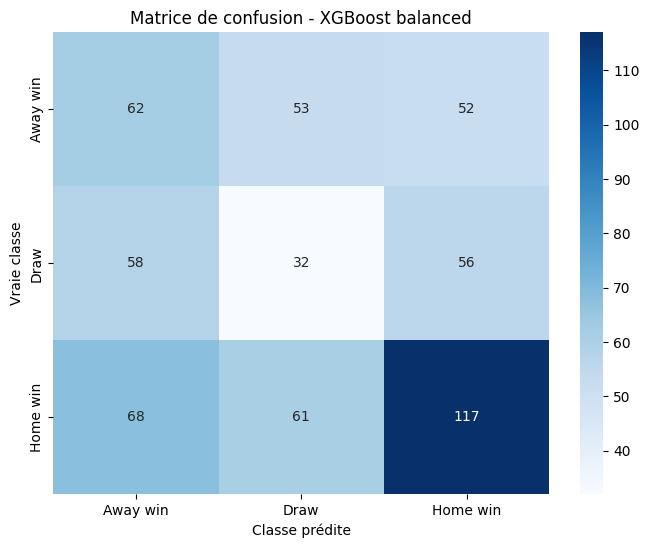

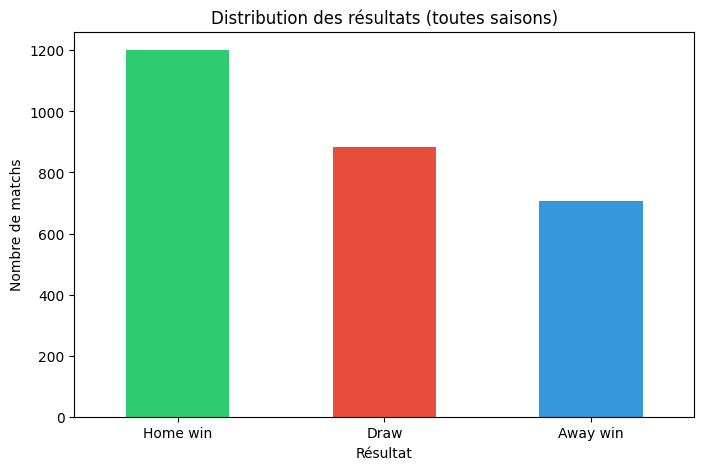

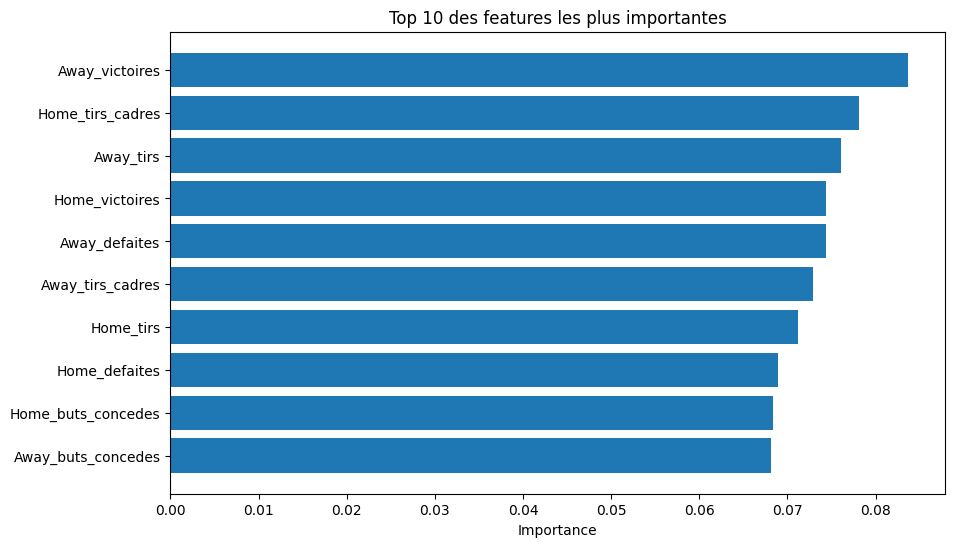

In [78]:
# Matrice de confusion visuelle
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_bal), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away win', 'Draw', 'Home win'],
            yticklabels=['Away win', 'Draw', 'Home win'])
plt.title('Matrice de confusion - XGBoost balanced')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Distribution des classes dans le dataset
plt.figure(figsize=(8, 5))
df['FTR'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title('Distribution des résultats (toutes saisons)')
plt.xlabel('Résultat')
plt.ylabel('Nombre de matchs')
plt.xticks([0, 1, 2], ['Home win', 'Draw', 'Away win'], rotation=0)
plt.show()

# Importance des features (XGBoost)
feature_importance = xgb_model_balanced.feature_importances_
features_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 des features les plus importantes')
plt.gca().invert_yaxis()
plt.show()